In [22]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
import numpy as np
import pandas as pd
import docx 
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
# Abre el documento de Word
doc_ciencia = docx.Document("ExportacionWordCREA_Ciencia.doc")
doc_deporte = docx.Document("ExportacionWordCREA_Deporte.doc")
doc_viaje = docx.Document("ExportacionWordCREA_Viaje.doc")

archivos = [doc_ciencia, doc_deporte, doc_viaje]

# Inicializa listas para los títulos y textos
titulos = []
documentos = []

# Inicializa una bandera para determinar si estamos en una sección de título o texto
en_titulo = True

# Recorre el contenido del documento
for doc in archivos:
    for paragraph in doc.paragraphs[2:]:
        if paragraph.text:  # Verifica si el párrafo no está vacío
            if en_titulo:
                titulos.append(paragraph.text)
            else:
                documentos.append(paragraph.text)
            # Cambia la bandera en_titulo en cada iteración
            en_titulo = not en_titulo

print(f"Numero de documentos: {len(documentos)}")

Numero de documentos: 491


In [29]:
documentos = [
    "Machine learning is a subfield of artificial intelligence.",
    "Artificial intelligence is revolutionizing various industries.",
    "Natural language processing is an important part of NLP.",
    "NMF is a technique for topic modeling."
]

In [52]:
nltk.download('stopwords')
nltk.download('wordnet')

# Definir las funciones de preprocesamiento
def preprocess_text(text):
    # Tokenización personalizada para mantener solo palabras (sin números ni signos de puntuación)
    tokenizer = RegexpTokenizer(r'\b[^\d\W]+\b')
    words = tokenizer.tokenize(text)
    
    # Eliminación de stopwords
    stop_words = set(stopwords.words('spanish'))  # Cambia 'spanish' por tu idioma
    words = [word for word in words if word.lower() not in stop_words]
    
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Lematización
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocess_text, min_df=0.02)
count_matrix = tfidf_vectorizer.fit_transform(documentos)
words = tfidf_vectorizer.get_feature_names_out()

# Create a CountVectorizer with custom preprocessing
#count_vectorizer = CountVectorizer(preprocessor=preprocess_text, min_df=0.01)

# Fit and transform the documents using the vectorizer
#count_matrix = count_vectorizer.fit_transform(documentos)
#words = np.array(count_vectorizer.get_feature_names_out())

# Convert the term frequency matrix to a Pandas DataFrame
#term_frequency_df = pd.DataFrame(count_matrix.toarray(), index=count_vectorizer.get_feature_names_out())


# Imprimir la matriz de frecuencia de términos preprocesada
#term_frequency_df.to_excel('frecuencia_terminos.xlsx')
#print(term_frequency_df)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\samue\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [53]:
from sklearn.decomposition import NMF

num_topics = 5
model = NMF(n_components=num_topics)

W = model.fit_transform(count_matrix)
H = model.components_

In [54]:
for topic_idx, topic in enumerate(H):
    print(f"Topic {topic_idx + 1}:")
    top_terms = [words[i] for i in topic.argsort()[:-7:-1]]
    print(", ".join(top_terms))

Topic 1:
ciencia, social, salud, antropología, conocimiento, científico
Topic 2:
deport, dijo, nunca, mujer, hijo, mano
Topic 3:
viajar, hacer, despué, día, ahí, así
Topic 4:
si, viajaba, semana, casa, bien, siempr
Topic 5:
medicina, ciencia, médico, liber, social, sistema


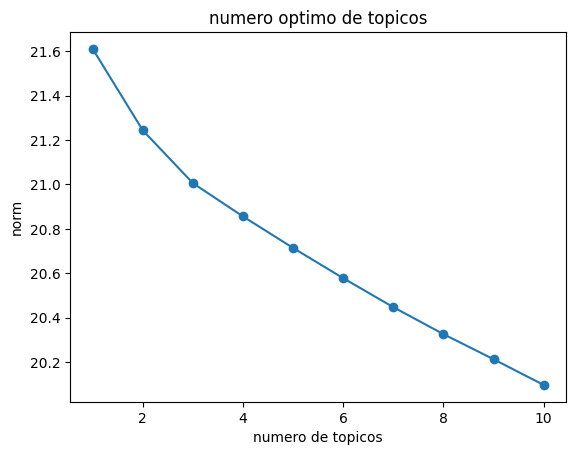

In [55]:
import matplotlib.pyplot as plt

num_topics_range = range(1, 11)
norms = []

for num_topics in num_topics_range:
    nmf_model = NMF(n_components=num_topics, random_state=1)
    W = nmf_model.fit_transform(count_matrix)
    H = nmf_model.components_
    approx = np.dot(W, H)
    norm = np.linalg.norm(count_matrix - approx)
    norms.append(norm)

# Plot the Frobenius norms against the number of topics
plt.plot(num_topics_range, norms, marker='o')
plt.xlabel('numero de topicos')
plt.ylabel('norm')
plt.title('numero optimo de topicos')
plt.show()





